In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


# loading libraries

In [4]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import nltk
from nltk.corpus import stopwords
import string
from transformers import BertTokenizer

In [5]:
dataset = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

In [6]:
cleaned_data = dataset.dropna()
print(cleaned_data.isnull().sum())
print(cleaned_data.shape)

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64
(19662, 11)


In [7]:
#cleaned_data = cleaned_data.drop(['Unnamed: 0'],axis = 1)

In [8]:
cleaned_data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


# 1.Visualization of features

In [9]:
# Selecting the relevant columns for the histogram plots
columns_of_interest = ['Clothing ID', 'Age', 'Positive Feedback Count']

figs = []

for column in columns_of_interest:
    fig = px.histogram(cleaned_data, x=column, title=f'Histogram of {column}', marginal='violin')
    figs.append(fig)

# Displaying the first histogram as an example
for i in range(len(figs)):
    figs[i].show()

In [10]:
fig1 = px.pie(cleaned_data, names='Rating', title='Pie Chart of Ratings')
fig1.show()

fig2 = px.pie(cleaned_data, names='Recommended IND', title='Pie Chart of Recommendation Indicator')
fig2.show()

stacked_bar = px.bar(cleaned_data, x="Division Name", color="Department Name", 
                     title="Stacked Bar Chart of Division and Department Names")
stacked_bar.show()

treemap = px.treemap(cleaned_data, path=['Division Name', 'Department Name', 'Class Name'],
                     title="Treemap of Division, Department, and Class Names")
treemap.show()

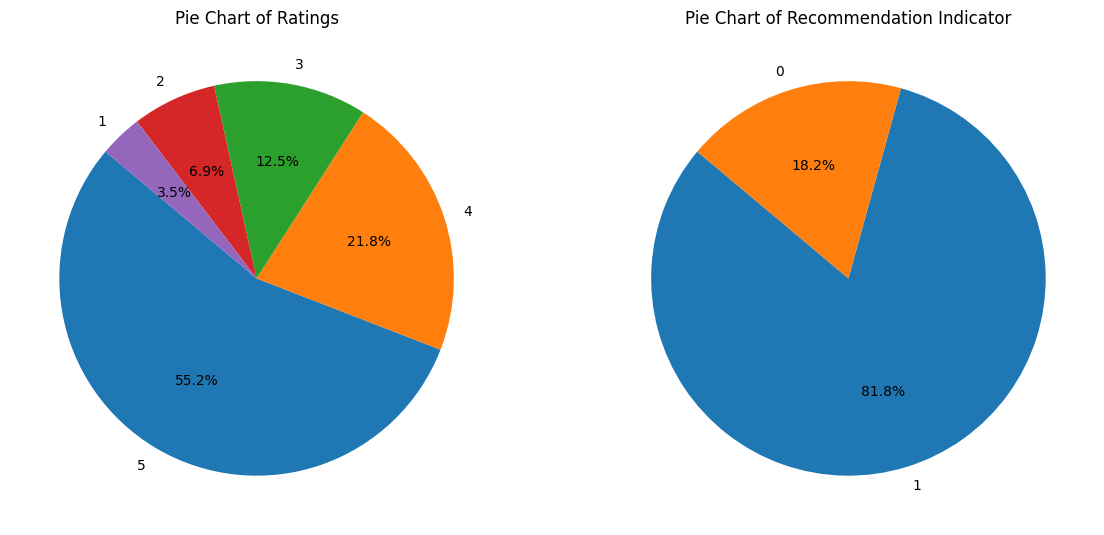

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



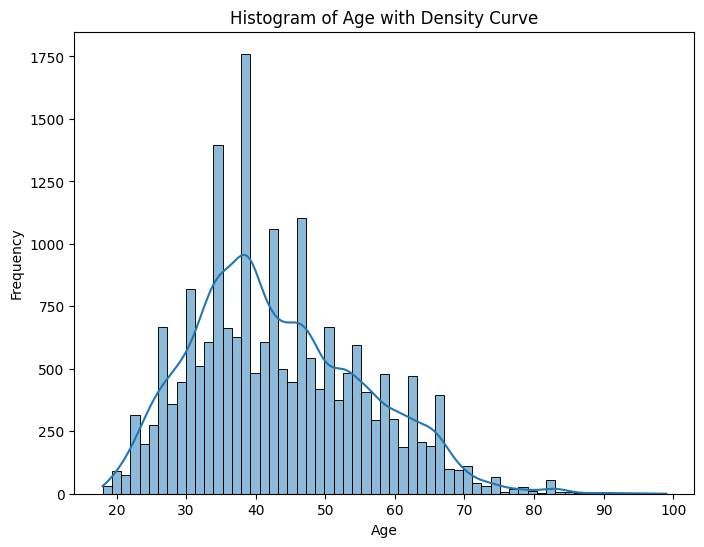

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



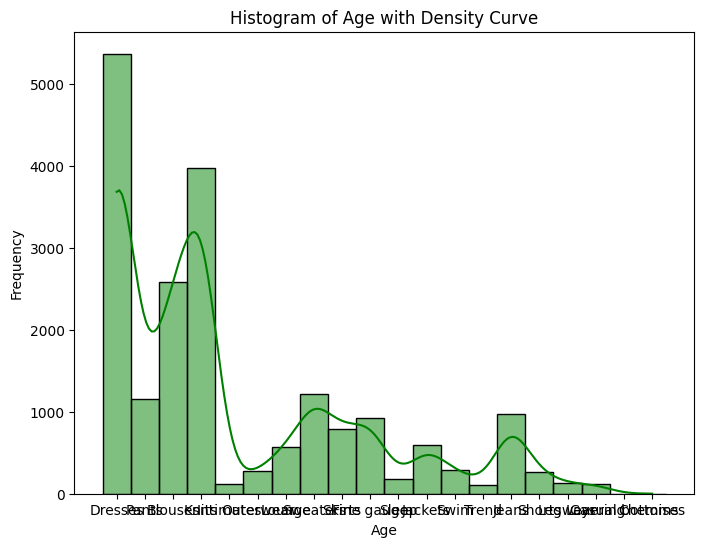

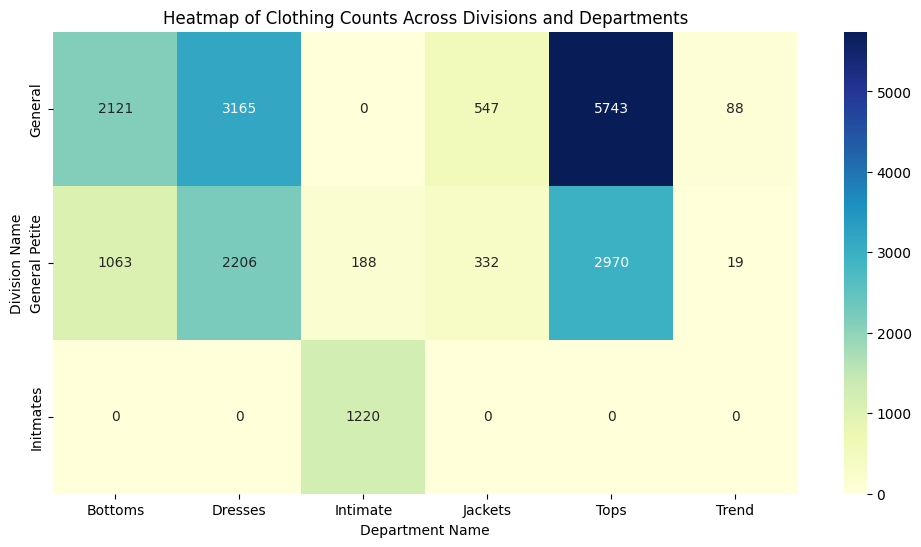

In [11]:
# Creating pie charts for 'Rating' and 'Recommended IND'
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

rating_counts = cleaned_data['Rating'].value_counts()
ax[0].pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Pie Chart of Ratings')

recommended_counts = cleaned_data['Recommended IND'].value_counts()
ax[1].pie(recommended_counts, labels=recommended_counts.index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('Pie Chart of Recommendation Indicator')

plt.show()

# Creating a histogram with a density curve for 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data['Age'], kde=True)
plt.title('Histogram of Age with Density Curve')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Creating a histogram with a density curve for 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(cleaned_data['Class Name'], kde=True,color = 'green')
plt.title('Histogram of Age with Density Curve')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

pivot_table = cleaned_data.pivot_table(index='Division Name', columns='Department Name', values='Clothing ID', 
                                       aggfunc='count', fill_value=0)

# 使用Seaborn绘制热图
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Heatmap of Clothing Counts Across Divisions and Departments')
plt.show()

# 2.data processing & feature enginering for numerical data

In [12]:
columns_of_interest = ['Division Name','Department Name','Class Name']
cleaned_data[columns_of_interest].nunique()

Division Name       3
Department Name     6
Class Name         20
dtype: int64

In [13]:
# Applying One-Hot Encoding to 'Division Name', 'Department Name', and 'Class Name'
encoded_data = pd.get_dummies(cleaned_data, columns=['Division Name', 'Department Name']).copy()

# Frequency encoding for 'Class Name'
frequency_encoding1 = encoded_data['Class Name'].value_counts(normalize=True)
frequency_encoding2 = encoded_data['Clothing ID'].value_counts(normalize=True)

# Mapping the frequencies to the original data
encoded_data['Class Name_Frequency'] = encoded_data['Class Name'].map(frequency_encoding1)
encoded_data['Clothing ID_Frequency'] = encoded_data['Clothing ID'].map(frequency_encoding2)
encoded_data.drop(columns=['Clothing ID','Class Name'],inplace = True)
encoded_data.head()

,Unnamed: 0,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Frequency,Clothing ID_Frequency
2,2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,True,False,False,False,True,False,False,False,False,0.273167,0.012766
3,3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,False,True,False,True,False,False,False,False,False,0.058844,0.001271
4,4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,True,False,False,False,False,False,False,True,False,0.131574,0.000203
5,5,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,True,False,False,False,True,False,False,False,False,0.273167,0.012257
6,6,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,False,True,False,False,False,False,False,True,False,0.202472,0.000915


In [31]:
ml_data = encoded_data.copy()
ml_data = ml_data.drop(columns=['Title', 'Review Text','Unnamed: 0'])

ml_data.head()

,Age,Rating,Recommended IND,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Frequency,Clothing ID_Frequency
2,60,3,0,0,True,False,False,False,True,False,False,False,False,0.273167,0.012766
3,50,5,1,0,False,True,False,True,False,False,False,False,False,0.058844,0.001271
4,47,5,1,6,True,False,False,False,False,False,False,True,False,0.131574,0.000203
5,49,2,0,4,True,False,False,False,True,False,False,False,False,0.273167,0.012257
6,39,5,1,1,False,True,False,False,False,False,False,True,False,0.202472,0.000915


# 3.NLP for text data

In [15]:
nlp_data = encoded_data[['Title','Review Text','Recommended IND']].copy()
nlp_data['Text'] = nlp_data['Title'] + ' ' + nlp_data['Review Text']
nlp_data = nlp_data[['Text', 'Recommended IND']]
nlp_data.head()

,Text,Recommended IND
2,Some major design flaws I had such high hopes ...,0
3,"My favorite buy! I love, love, love this jumps...",1
4,Flattering shirt This shirt is very flattering...,1
5,Not for the very petite I love tracy reese dre...,0
6,Cagrcoal shimmer fun I aded this in my basket ...,1


# 4.Tokenizing with Bert Pre-train Model

In [16]:
# 1. 加载预训练的BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


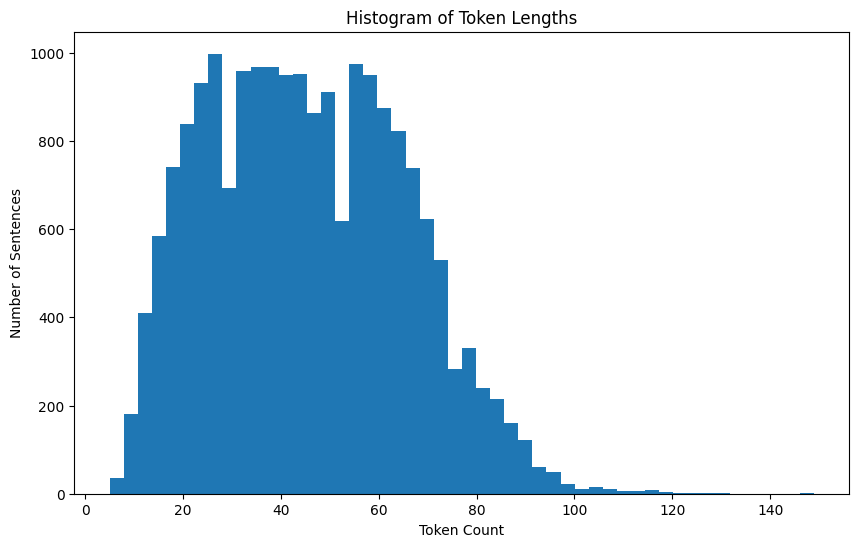

In [17]:
# 2. 去除停用词
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 获取标点符号
punctuations = string.punctuation

def clean_text(text):
    # 分词
    tokens = tokenizer.tokenize(text)
    # 去除停用词和标点符号
    tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    # 重建文本
    return ' '.join(tokens)

# 应用清洁函数
nlp_data['Text'] = nlp_data['Text'].apply(clean_text)

# 3. 分词并统计句子长度
token_lengths = []
for text in nlp_data['Text']:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

# 4. 绘制句子长度的直方图
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.title('Histogram of Token Lengths')
plt.xlabel('Token Count')
plt.ylabel('Number of Sentences')
plt.show()

In [18]:
nlp_data.head()

,Text,Recommended IND
2,major design flaws high hopes dress really wan...,0
3,favorite buy love love love jumps ##uit fun fl...,1
4,flat ##tering shirt shirt flat ##tering due ad...,1
5,petite love tracy reese dresses one petite 5 f...,0
6,ca ##gr ##co ##al shi ##mmer fun ad ##ed baske...,1


## padding sequence we choose 70 according to the above histplot

In [36]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

# 分词并转换为标记ID
input_ids = [tokenizer.encode(text, add_special_tokens=True) for text in nlp_data['Text']]

# 截断/填充句子
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

# 3. 注意力掩码准备
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [37]:
input_ids_ = input_ids.copy()
attention_masks_ = attention_masks.copy()

# 5.Modeling

In [21]:
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

In [38]:
# 1. 数据分割
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_, nlp_data['Recommended IND'], 
                                                                                    random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks_, input_ids_,
                                                       random_state=2018, test_size=0.1)

# 使用相同的分割索引分割ML数据
train_ml_data, validation_ml_data,= train_test_split(ml_data.drop(['Recommended IND'],axis = 1).copy(), test_size=0.1, random_state=2018)

In [39]:
print(train_inputs.shape)
print(train_ml_data.shape)

(17695, 64)
(17695, 14)


In [40]:
# 2. 转换为Tensor
train_inputs = tf.convert_to_tensor(train_inputs)
validation_inputs = tf.convert_to_tensor(validation_inputs)
train_labels = tf.convert_to_tensor(train_labels)
validation_labels = tf.convert_to_tensor(validation_labels)
train_masks = tf.convert_to_tensor(train_masks)
validation_masks = tf.convert_to_tensor(validation_masks)

# 转换为Tensor
train_ml_data = train_ml_data.astype(int)
validation_ml_data = validation_ml_data.astype(int)
# 转换为Tensor
train_ml_data = tf.convert_to_tensor(train_ml_data.values)
validation_ml_data = tf.convert_to_tensor(validation_ml_data.values)
train_ml_data = tf.convert_to_tensor(train_ml_data)
validation_ml_data = tf.convert_to_tensor(validation_ml_data)

In [41]:
# 3.BERT分支
input_ids = Input(shape=(64,), dtype=tf.int32, name='input_ids') 
attention_masks = Input(shape=(64,), dtype=tf.int32, name='attention_masks')
bert_output = bert(input_ids, attention_mask=attention_masks)[1]
bert_output = Dense(32, activation='relu')(bert_output)
bert_output = Dropout(0.4)(bert_output)
bert_output = Dense(32, activation='relu')(bert_output)

for layer in bert.layers:
    layer.trainable = False

# 4.ML数据分支
ml_input = Input(shape=(14,), name='ml_input') # num_ml_features为ML数据的特征数量
ml_output = Dense(64, activation='relu')(ml_input)
ml_output = Dropout(0.5)(ml_output)  
ml_output = Dense(32, activation='relu')(ml_output)  
ml_output = Dense(16, activation='relu')(ml_output)  

# 合并两个分支
combined = Concatenate()([bert_output, ml_output])
combined_output = Dense(64, activation='relu')(combined)
combined_output = Dense(1, activation='sigmoid')(combined_output)

# 构建和编译模型
model = Model(inputs=[input_ids, attention_masks, ml_input], outputs=combined_output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 64)]                 0         []                            
 r)                                                                                               
                                                                                                  
 ml_input (InputLayer)       [(None, 14)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',     

In [43]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# 配置模型检查点
checkpoint = ModelCheckpoint(
    'model_checkpoint.h5',  # 模型保存路径和文件名
    monitor='val_loss',  # 监控验证集损失
    verbose=1,  # 输出保存信息
    save_best_only=True,  # 只保存最佳模型
    mode='min'  # 保存最小化指标的模型
)


# 配置早停
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控验证集损失
    patience=10,  # 2轮无提升则停止
    restore_best_weights=True  # 恢复到最佳模型
)

In [44]:
# 训练模型
history = model.fit(
    [train_inputs, train_masks, train_ml_data], train_labels,
    batch_size=32,
    epochs=30,  # 可以设置一个较大的数，因为早停会在训练过程中终止
    validation_data=([validation_inputs, validation_masks, validation_ml_data], validation_labels),
    callbacks=[early_stopping,checkpoint]  # 使用早停回调
)

Epoch 1/30
553/553 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.8122
Epoch 1: val_loss improved from inf to 0.29053, saving model to model_checkpoint.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



553/553 [==============================] - 81s 117ms/step - loss: 0.5044 - accuracy: 0.8122 - val_loss: 0.2905 - val_accuracy: 0.8836
Epoch 2/30
553/553 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8853
Epoch 2: val_loss improved from 0.29053 to 0.23015, saving model to model_checkpoint.h5
553/553 [==============================] - 61s 111ms/step - loss: 0.2788 - accuracy: 0.8853 - val_loss: 0.2302 - val_accuracy: 0.8978
Epoch 3/30
553/553 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9082
Epoch 3: val_loss improved from 0.23015 to 0.17541, saving model to model_checkpoint.h5
553/553 [==============================] - 61s 110ms/step - loss: 0.2205 - accuracy: 0.9082 - val_loss: 0.1754 - val_accuracy: 0.9232
Epoch 4/30
553/553 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9179
Epoch 4: val_loss did not improve from 0.17541
553/553 [==============================] - 60s 108ms/step - loss: 0.1934 - accuracy: 0.

In [ ]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# if tf.test.gpu_device_name():
#     print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
# else:
#     print("Please install GPU version of TF")

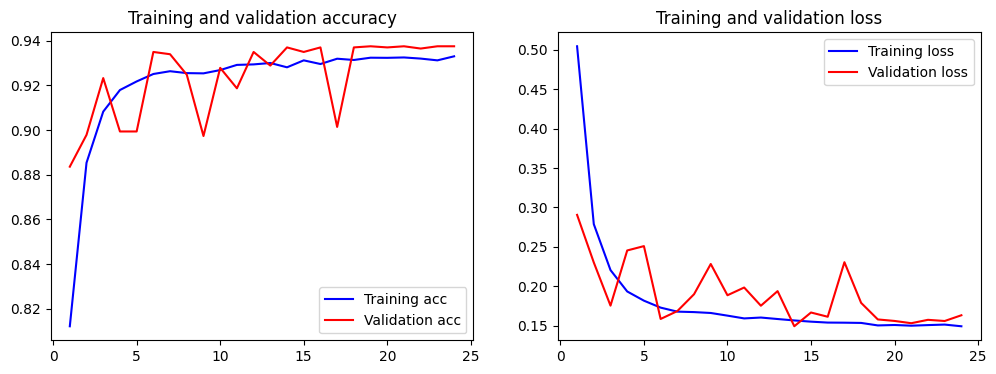

62/62 [==============================] - 9s 90ms/step
Accuracy: 0.9369598373157092
Recall: 0.9330413016270338
Precision: 0.9887267904509284


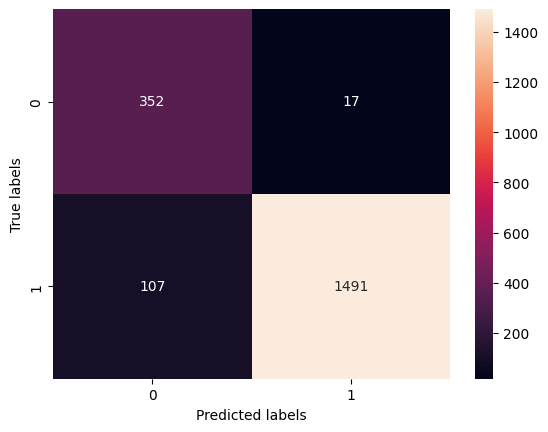

In [45]:
# 提取训练历史数据
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# 绘制训练和验证的准确率曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# 绘制训练和验证的损失曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 对验证集进行预测
predictions = model.predict([validation_inputs, validation_masks, validation_ml_data])

# 计算性能指标
y_pred = np.round(predictions).flatten()
y_true = validation_labels.numpy()  # 如果validation_labels是Tensor

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}")

# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


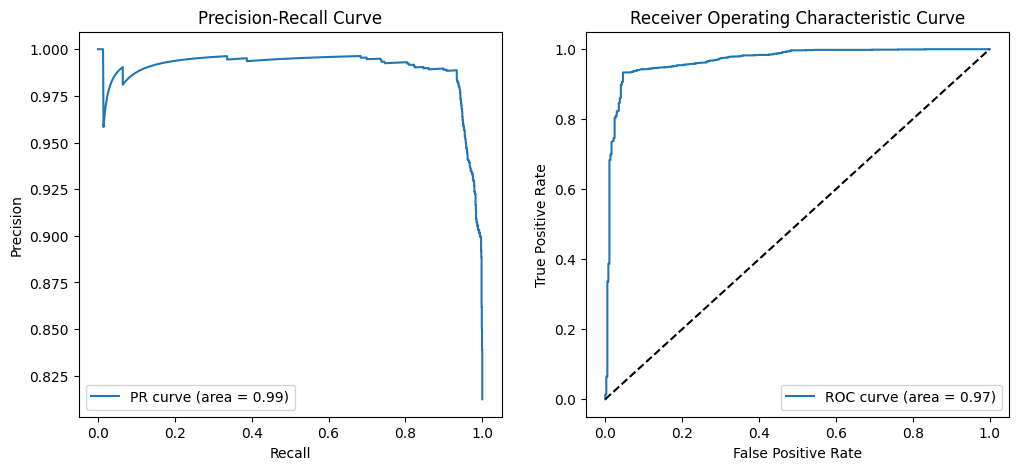

In [46]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# 计算PR曲线
precision, recall, _ = precision_recall_curve(y_true, predictions.ravel())
pr_auc = auc(recall, precision)

# 绘制PR曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# 计算ROC曲线
fpr, tpr, _ = roc_curve(y_true, predictions.ravel())
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='best')

plt.show()
